**Objective**: Test which blind exploration regime is optimal.
Does Lévy walk like motion has an advantage over ballistic motion?

Considering
- independent
- homogenous (behave the same)
- not evolving

agents that are randomly placed in the environment.

Because of this it does not matter whether we do a lot of iterations with a single agent or one iteration with many agents.

TODO: maybe it does matter, because food is distributed differently, no food is distributed the same for all iterations
TODO next randomly regenerate food positions at every iteration

In [4]:
import os
os.chdir(os.path.join(os.getcwd(), "../code"))

In [5]:
from environment import Environment
from simulation import Params
from data_io import initialize_epoch_data, save_simulation_context, save_epoch_data, update_epoch_data, update_meal_timelines
from simulation import Simulation
import numpy as np
from agent import LévyAgent, BallisticAgent
from visualization import animate_single_iteration

NUM_FOOD = 30
SIZE = 50
VELOCITY = 1
EAT_RADIUS = 1
NUM_ITERATIONS = 1
POPULATION_SIZE = 2
TOTAL_TIME = SIZE*5 - 1
DELTA_T = 1

params = Params(
    num_food = NUM_FOOD,
    size = SIZE,
    velocity = VELOCITY,
    eat_radius = EAT_RADIUS,
    iterations_per_epoch = NUM_ITERATIONS,
    num_epochs = 1,
    population_size = POPULATION_SIZE,
    total_time = TOTAL_TIME,
    delta_t = DELTA_T,
    empty = False,
    border_buffer = 10,
    food_buffer = 2,
    slow_velocity = VELOCITY,
    fast_velocity = VELOCITY,
    slow_perception_radius = EAT_RADIUS,
    fast_perception_radius = EAT_RADIUS,
)

environment = Environment(params)
environment.walls = []
# environment.custom_food_positioning()
# environment.num_food = len(environment.food_positions)
# params.num_food = environment.num_food

folder = 'exploration_study'
save_simulation_context(folder, environment, params)


# Lévy Agents

Animating 1/1: 100%|█████████▉| 249/250 [00:41<00:00,  3.42frame/s]

Safed animation under:
/home/lewin/levy-agent-simulation/data/exploration_study
8.0


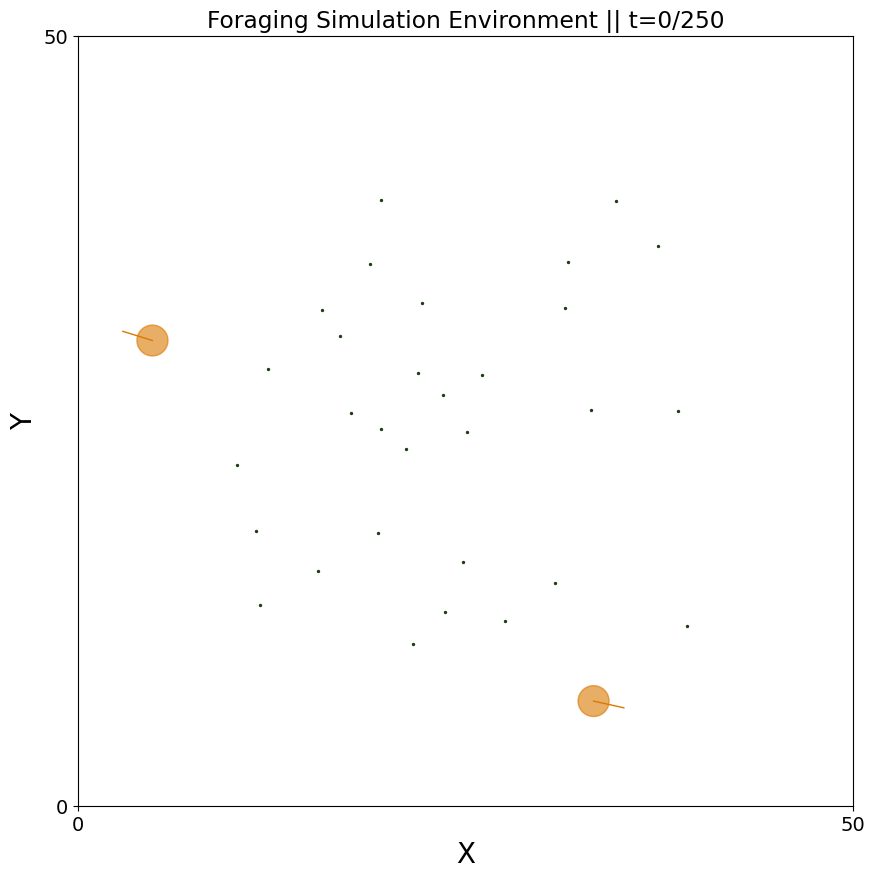

In [6]:
population = []
for _ in range(params.population_size):
    agent = LévyAgent(params, VELOCITY)
    population.append(agent)

data = initialize_epoch_data(params)
sim = Simulation(params)

for iteration in range(sim.iterations_per_epoch):
    sim.recycle_agents(population, environment, step=0)
    for step in range(params.simulation_steps - 1):
        for agent in population:
            agent.perceive(environment)
            if agent.pending_steps == 0:
                agent.choose_action()
            agent.pending_steps -= 1
            new_position = agent.position + np.array([np.cos(agent.direction), np.sin(agent.direction)]) * agent.velocity * params.delta_t
            agent.move(new_position, params.size)
        sim.store_positions(population, step + 1)
    sim.store_consumed_meals(population)
    update_meal_timelines(data, sim.iteration, population)
    update_epoch_data(data, sim.iteration, sim.trajectory_log, sim.meals_per_iteration)
    sim.iteration += 1

save_epoch_data(folder + '/levy_data', data, None, params.num_epochs)
animate_single_iteration(params.iterations_per_epoch - 1, environment, params, data, folder, 'levy', 0)
print(data['meals'].values.sum())

# Ballistic Agents

Animating 1/1: 100%|█████████▉| 249/250 [00:41<00:00,  3.25frame/s]

Safed animation under:
/home/lewin/levy-agent-simulation/data/exploration_study
20.0


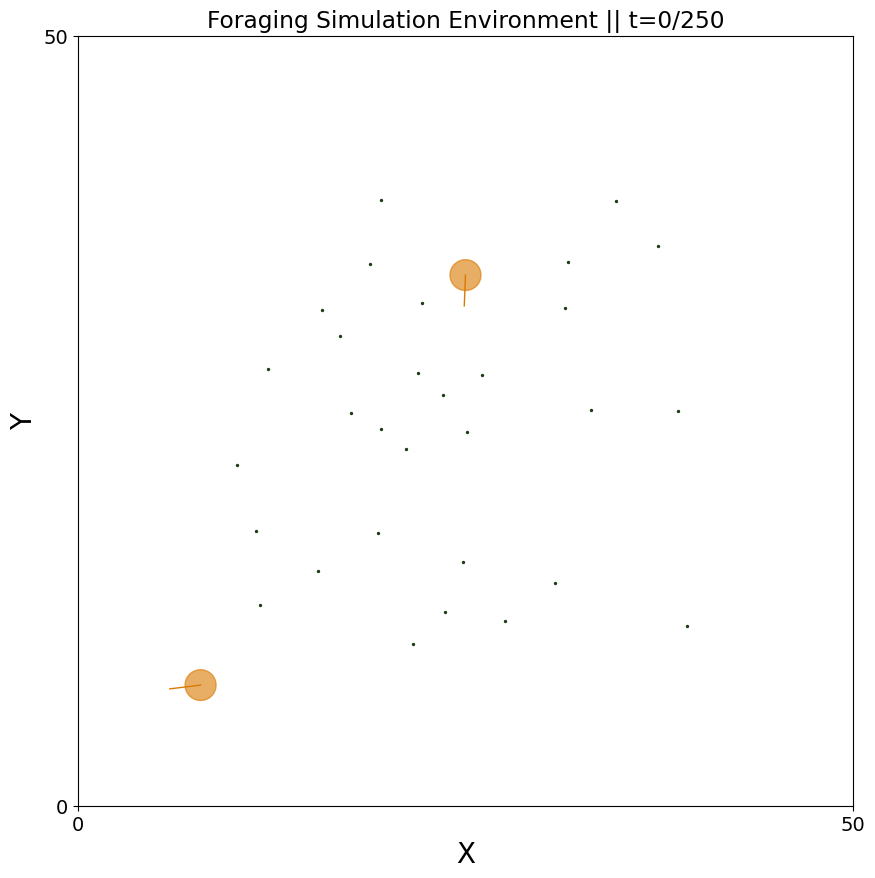

In [7]:

population = []
for _ in range(params.population_size):
    agent = BallisticAgent(params, VELOCITY)
    population.append(agent)

data = initialize_epoch_data(params)
sim = Simulation(params)

for iteration in range(sim.iterations_per_epoch):
    sim.recycle_agents(population, environment, step=0)
    for step in range(params.simulation_steps - 1):
        for agent in population:
            agent.perceive(environment)
            new_position = agent.position + np.array([np.cos(agent.direction), np.sin(agent.direction)]) * agent.velocity * params.delta_t
            agent.move(new_position, params.size)
        sim.store_positions(population, step + 1)
    sim.store_consumed_meals(population)
    update_meal_timelines(data, sim.iteration, population)
    update_epoch_data(data, sim.iteration, sim.trajectory_log, sim.meals_per_iteration)
    sim.iteration += 1

animate_single_iteration(params.iterations_per_epoch - 1, environment, params, data, folder, 'ballistic', 0)
print(data['meals'].values.sum())